# Convolutional Neural Network for Face(Happy,Sad) Detection 
# FER-2013 Dataset 
# https://www.kaggle.com/datasets/msambare/fer2013

## Read the dataset

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import zipfile
with zipfile.ZipFile("/content/fer-2013.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

## Determine shape of the data

In [2]:
train_path = "/content/targetdir/fer-2013/train"
test_path = "/content/targetdir/fer-2013/test"
IMG_WIDTH = 48
IMG_HEIGHT = 48
def read_dataset(dataset_root_path):
    img_data_array=[]
    class_name=[]
    for dir_level_1 in os.listdir(dataset_root_path):
                for file in os.listdir(os.path.join(dataset_root_path, dir_level_1)):
                    image_path= os.path.join(dataset_root_path, dir_level_1,file)
                    image= cv2.imread(image_path)
                    image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                    image=np.array(image)
                    image = image.astype('float32')
                    image = image / 255
                    img_data_array.append(image)
                    class_name.append(dir_level_1)
    return img_data_array, class_name

In [4]:
from tensorflow.keras.utils import to_categorical
import pandas as pd

train_data , train_class_name = read_dataset(train_path)
test_data ,  test_class_name = read_dataset(test_path)

train_data = np.array(train_data)
test_data = np.array( test_data)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1], train_data.shape[2],1)
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1], test_data.shape[2],1)

print(train_data.shape)
print(test_data.shape)
img_width, img_height, img_num_channels = train_data.shape[1], train_data.shape[2], train_data.shape[3]
input_shape = (img_width, img_height, img_num_channels)

# One-Hot Encoding data
no_classes = len(np.unique(train_class_name))-1

train_class_name, uniques = pd.factorize(train_class_name)
train_class_name = to_categorical(np.asarray(train_class_name))[:,0]

test_class_name = to_categorical(np.asarray(pd.factorize(test_class_name)[0]))[:,0]


(9807, 48, 48, 1)
(3021, 48, 48, 1)


## Create the model

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

model = Sequential()

model.add(Conv2D(40, kernel_size=(5, 5), activation='leaky_relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(20, kernel_size=(3, 3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='leaky_relu')) 

model.add(Dense(no_classes, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 40)        1040      
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 40)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 20)        7220      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 20)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 20)        0         
                                                                 
 flatten (Flatten)           (None, 2000)              0

## Compile the model

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Fit the data to the model

In [7]:
no_epochs = 15
batch_size = 50 
validation_split = 0.1
callback = callbacks.EarlyStopping(monitor="val_loss", patience=2)
history = model.fit(train_data, train_class_name,
            batch_size=batch_size,
            epochs=no_epochs,
            callbacks=[callback],
            verbose=2,
            validation_split=validation_split
            )

Epoch 1/15
177/177 - 29s - loss: 0.6220 - accuracy: 0.6594 - val_loss: 0.5674 - val_accuracy: 0.7085 - 29s/epoch - 164ms/step
Epoch 2/15
177/177 - 23s - loss: 0.5441 - accuracy: 0.7318 - val_loss: 0.5643 - val_accuracy: 0.6871 - 23s/epoch - 128ms/step
Epoch 3/15
177/177 - 23s - loss: 0.5112 - accuracy: 0.7488 - val_loss: 0.5650 - val_accuracy: 0.6748 - 23s/epoch - 128ms/step
Epoch 4/15
177/177 - 22s - loss: 0.4783 - accuracy: 0.7719 - val_loss: 0.5539 - val_accuracy: 0.6840 - 22s/epoch - 127ms/step
Epoch 5/15
177/177 - 23s - loss: 0.4592 - accuracy: 0.7767 - val_loss: 0.5023 - val_accuracy: 0.7156 - 23s/epoch - 131ms/step
Epoch 6/15
177/177 - 22s - loss: 0.4384 - accuracy: 0.7940 - val_loss: 0.4534 - val_accuracy: 0.7574 - 22s/epoch - 124ms/step
Epoch 7/15
177/177 - 23s - loss: 0.4236 - accuracy: 0.8025 - val_loss: 0.4397 - val_accuracy: 0.7635 - 23s/epoch - 127ms/step
Epoch 8/15
177/177 - 24s - loss: 0.4049 - accuracy: 0.8153 - val_loss: 0.5197 - val_accuracy: 0.7125 - 24s/epoch - 133

## evaluate the model

In [8]:
score = model.evaluate(test_data, test_class_name, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.440010130405426 / Test accuracy: 0.7881495952606201


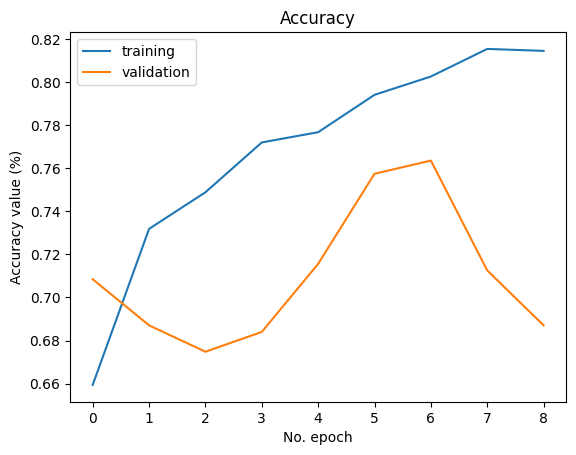

In [9]:
#Validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['training','validation'])
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

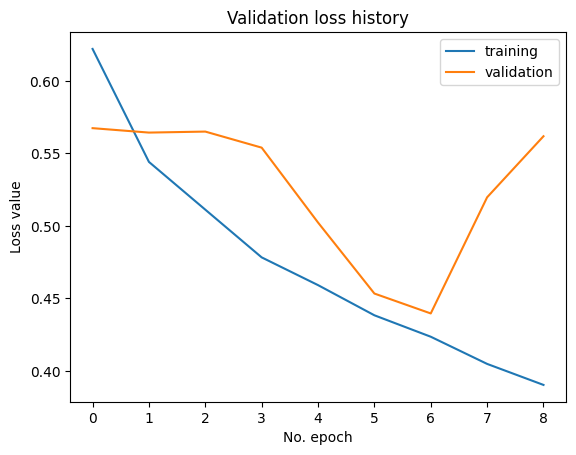

In [10]:
#Validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.legend(['training','validation'])
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

In [11]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
